# Clustering - USA Single site

### Observations

* it is risky to let the clustering methodologies pick the extreme days without any constraints.
Indeed it can happen (and did happen) that, instead of picking the most "extreme" days from each cluster of a bunch of days that do not fit exactly in any cluster, the algorithm is going to isolate a bunch of days very similar to each other but different from the rest, i.e. a sort of $(n+1)^{th}$ cluster, which is not what we wanted. 
If we pass constraints (on total values, peaks etc.) the algorithm will be pushed to isolate extreme days that make these conditions unfeasable

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

input_path = Path('../data/US_single_site_preprocessed')
output_path = Path('../data/US_single_site_results')
graphs_path = Path('../data/US_single_site_graphs')

In [1]:
from pyomo import environ as pe

### Import data

In [2]:
def get_input_prefix(state, n_households):
    return '{}_{}_'.format(state, n_households)

In [3]:
def load_preprocessed_data(state, n_households, year=2015, measures=['cooling', 'heating', 'electricity']):
    
    start = pd.datetime(year,1,1)
    end   = pd.datetime(year+1,1,1)
    index = pd.DatetimeIndex(start=start, end=end, freq='h')[:-1]

    prefix = get_input_prefix(state, n_households)
    
    d = {}
    
    for measure in measures:
        _filename = prefix + measure + '.csv'
        d[measure] = pd.read_csv(input_path / _filename, header=None, squeeze=True)

    df = pd.concat(d.values(), axis=1, keys=d.keys())
    df.set_index(index, inplace=True)
    
    return df

In [4]:
state = 'NY'
n_households = 45
year = 2015
measures = ['cooling', 'heating', 'electricity']

df = load_preprocessed_data(state, n_households, year, measures)

### import distance data

In [5]:
def load_distance_data(state, n_households):
    
    prefix = get_input_prefix(state, n_households)
    _filename = prefix + 'distance.csv'
    
    dist = np.loadtxt(input_path / _filename, delimiter=',')
    n_days = dist.shape[0]
    
    dist_df = pd.DataFrame(dist, index=np.arange(n_days)+1, columns=np.arange(n_days)+1)
    
    return dist_df, n_days

In [6]:
dist_df, n_days = load_distance_data(state, n_households)

### Cluster

In [9]:
import sys

milp_clustering_path = Path('../milp_clustering')

if str(milp_clustering_path) not in sys.path:
    sys.path.append(str(milp_clustering_path))
    
import k_medoids_milp

from pyomo import environ as pe

In [10]:
def get_pyomo_input_dictionary(data_dict, namespace=None):
    for k, v in data_dict.items():
        if not isinstance(v, dict):
            data_dict[k] = {None:v}
    
    return {namespace:data_dict}

In [11]:
n_clusters = 6
n_extreme_days = 6

data = dict(
    n_days = n_days,
    n_clusters = n_clusters,
    n_extreme_days = n_extreme_days,
    distance = dist_df.stack().to_dict()
)

data = get_pyomo_input_dictionary(data)

In [12]:
m = k_medoids_milp.create_model()

cm = m.create_instance(data=data)

with pe.SolverFactory("cplex") as opt:

    # opt.options['absmipgap'] = 0.1

    solver_manager = pe.SolverManagerFactory('neos')

    results = solver_manager.solve(cm, opt=opt)

cm.solutions.load_from(results)

Job 6069072 submitted to NEOS, password='JlNfnhGg'
Check the following URL for progress report :
https://www.neos-server.org/neos/cgi-bin/nph-neos-solver.cgi?admin=results&jobnumber=6069072&pass=JlNfnhGg
Job 6069072 dispatched
password: JlNfnhGg
---------- Begin Solver Output -----------
Condor submit: 'neos.submit'
Condor submit: 'watchdog.submit'
Job submitted to NEOS HTCondor pool.


### Extract results

In [169]:
y = pd.Series(cm.y.get_values())
z = pd.Series(cm.z.get_values()).unstack()

# get dictionary like k:representative_day
clusters_repr_d = dict(enumerate(y.index[y>0]))

# get dictionary like k: [list of represented days]
clusters_members_d = {k: z.index[z.loc[rep,:] > 0].tolist() 
                      for k, rep in clusters_repr_d.items()}

# get dictionary like d:k -- value is n_clusters if the day is extreme
day_to_cluster_d = dict(zip(np.arange(n_days)+1, np.ones(n_days)*n_clusters))
day_to_cluster_d.update({d:k for k, l in clusters_members_d.items() for d in l})

# get series like day_of_year:k
labeled = pd.Series(day_to_cluster_d).sort_index()

# get dict like d:repr
day_to_repr_d = {d: clusters_repr_d.get(k, d) for d, k in day_to_cluster_d.items()}

start = pd.datetime(year, 1, 1)
end   = pd.datetime(year+1, 1, 1)

index = pd.DatetimeIndex(start=start, end=end, freq='d', closed='left')

labeled = pd.Series(labeled.values, index=index, dtype=int)

weekly_df = labeled.rename('cluster').to_frame() \
    .assign(dayofweek=labeled.index.weekday, week=labeled.index.weekofyear) \
    .set_index(['dayofweek', 'week']).cluster.unstack(level=0)

### save results

In [170]:
def get_output_prefix(state, n_households, n_clusters, n_extreme_days):
    
    prefix = get_input_prefix(state, n_households)
    output_prefix = prefix + '{}k_{}ed_'.format(n_clusters, n_extreme_days)
    
    return output_prefix

In [171]:
output_prefix = get_output_prefix(state, n_households, n_clusters, n_extreme_days)

y.to_csv(output_path / (output_prefix + 'y.csv'), index=True)
z.to_csv(output_path / (output_prefix + 'z.csv'), index=True)

### Plot calendar

In [172]:
def plot_calendar_heatmap(weekly_df)

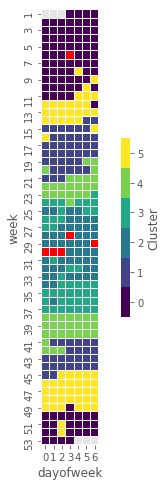

In [172]:
cmap = plt.get_cmap('viridis', n_clusters)

# set color for extreme days (use vmax in heatmap to make this work)
cmap.set_over('r')

# gridspec_kw={'width_ratios' :[10, 1]}
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(weekly_df, cmap=cmap, vmax=n_clusters-1, 
            linecolor='w', linewidths=0.01, square=True,
            cbar_kws={'fraction' :0.02}, ax=ax)

cbar = ax.collections[0].colorbar
cbar.set_ticks((np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters)
cbar.set_ticklabels(range(n_clusters))
cbar.set_label('Cluster');

_filename = output_prefix + 'calendar.png'
fig.savefig(graphs_path / _filename, dpi=400)

### Plot LDC

In [173]:
# get dataframe with days (days as columns, time/measure as rows)

days_df = df.assign(
    date=df.index.date, 
    time=df.index.time
).rename_axis('measure', axis=1) \
    .set_index(['date', 'time']) \
    .stack().unstack(level=0)

In [174]:
# get dataframe of days replaced by their representative day

synth_days_df = pd.concat({d:days_df.iloc[:,day_to_repr_d[d] + 1] 
                           for d in days_df.columns.dayofyear}
                         ).unstack(level=0)

synth_days_df.columns = days_df.columns

In [175]:
# get LDC and synth_LDC
ldc_d = {}
synth_ldc_d = {}

for measure in measures:
    
    ldc_d[measure] = df[measure].sort_values(ascending=False).reset_index(drop=True)
    
    synth_ldc_d[measure] = synth_days_df.xs(measure, level='measure').stack() \
        .sort_values(ascending=False).reset_index(drop=True)

ldc_df = pd.concat(ldc_d.values(), keys=ldc_d.keys(), axis=1)
synth_ldc_df = pd.concat(synth_ldc_d.values(), keys=synth_ldc_d.keys(), axis=1)

_filename = output_prefix + 'ldc.csv'
ldc_df.to_csv(output_path / _filename, index=True)

_filename = output_prefix + 'ldc_clustered.csv'
synth_ldc_df.to_csv(output_path / _filename, index=True)

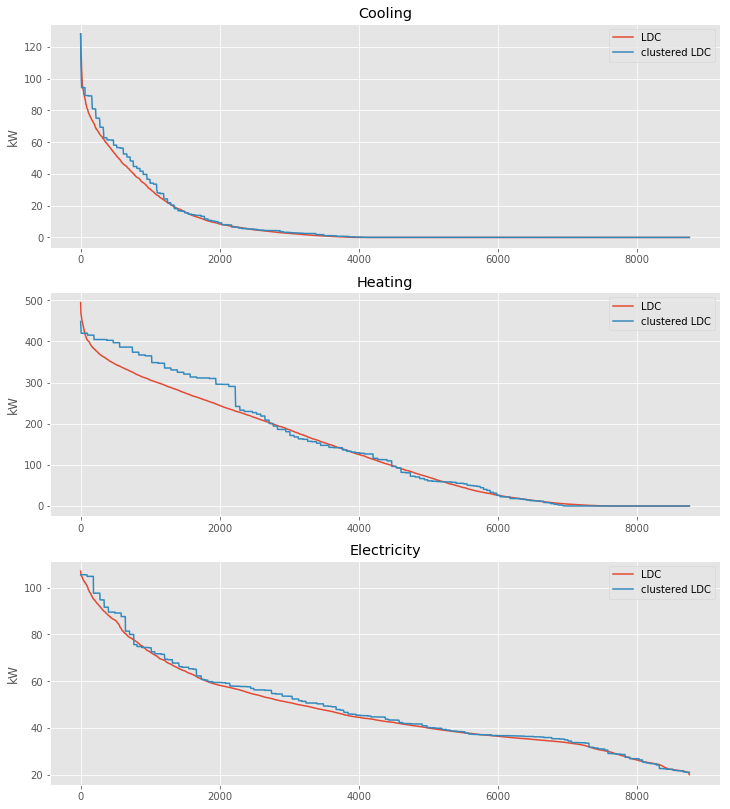

In [176]:
fig, axes = plt.subplots(len(ldc_df.columns), figsize=(12,14))

for i, measure in enumerate(ldc_df.columns):
    
    ldc_df[measure].plot(ax=axes[i], label='LDC')
    synth_ldc_df[measure].plot(ax=axes[i], label='clustered LDC')
    
    axes[i].set_title(measure.title())
    axes[i].legend();
    axes[i].set_ylabel('kW');
    
    _filename = output_prefix + 'LDC_plot.png'
    fig.savefig(graphs_path / _filename, dpi=400)